# Team 14 The Catalyst
  On This Notebook We Will Solve The House Prices Using Advance Regression Techniques


### Import The Important Packages For Data Viewing Data Analysis,Data Manipulation,Mechine-Learning 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#importing all the liabriaries we will need to boost our model 
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Importing Our Datasets

In [3]:
hp_train = pd.read_csv('https://raw.githubusercontent.com/K1TS/mypackage/master/train.csv')
hp_test = pd.read_csv('https://raw.githubusercontent.com/K1TS/House-Prices-Advanced-Regression-Techniques/master/test.csv')
sample_supmition =pd.read_csv('https://raw.githubusercontent.com/K1TS/House-Prices-Advanced-Regression-Techniques/master/sample_submission.csv')
train_length=1460
saleprice=pd.DataFrame(hp_train.iloc[:,-1])

In [4]:
# We are Concatinating the two datasets so it can be easy to clean data at once for future engineering   
df_all=pd.concat([hp_train.drop(columns=['SalePrice']), hp_test])

In [5]:
# The Shape Of The Two DataSets Combined
df_all.shape

(2919, 80)

In [6]:
df_all.head()# viewing the dataset to avoid large output space

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### The Correlation Graphs

Check Correlation Of Columns To The Target Columns To See Which Columns We Should Drop

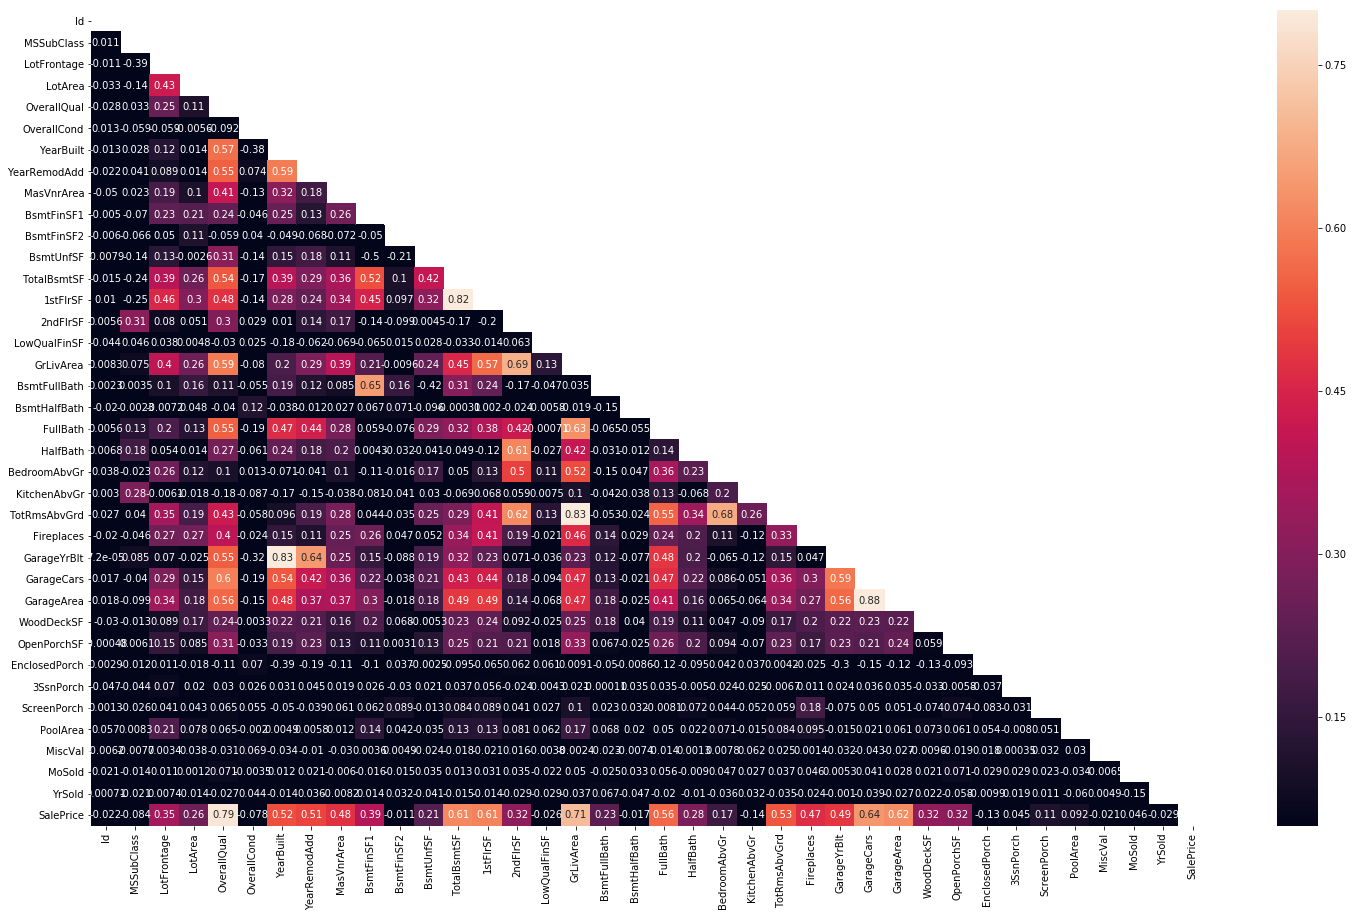

In [7]:
#We Decided To Cut The Correlation Graph In Half Since The Upper Part Is Really Repetition Of the Lower Triangle  
corr_matrix = hp_train.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr_matrix, mask=mask, vmax=0.8, vmin=0.05, annot=True);



Brief Correlation Graph Showing Positive And Negative Correlation 

Text(0.5, 1.0, 'Brief Correlation Graph of Features and Sales Price')

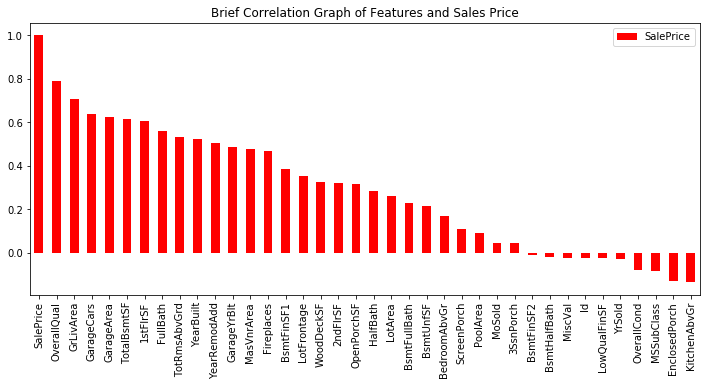

In [8]:
#COLUMNS THAT ARE CORRELATED TO THE SALES PRICE AND INVESLY CORRELATED TO SALES PRICE 
df=pd.DataFrame(hp_train.corr()['SalePrice'].sort_values(ascending=False))
df.plot(kind='bar',figsize=(12,5),color='red')
plt.title('Brief Correlation Graph of Features and Sales Price')




### The Columns That Are More Correlated With The Target Are Bellow
* This Columns Are The Columns That Have Same Relationship To Each Other And Are Correlated To The Sales Price column 
* we will Need To Drop 5 Columns In The Below List That Are Related To Each Other Since They Have The Same Information 

  * YearBuilt or GarageYrBlt
  * GrLivArea or TotRmsAbvGrd
  * GarageCars or GarageArea
  * TotalBsmtSF or 1stFlrSF
  * SalePrice or overalqal

### Visulization Of The Columns With High Correlation 

Text(0.5, 1.0, 'OverallQual')

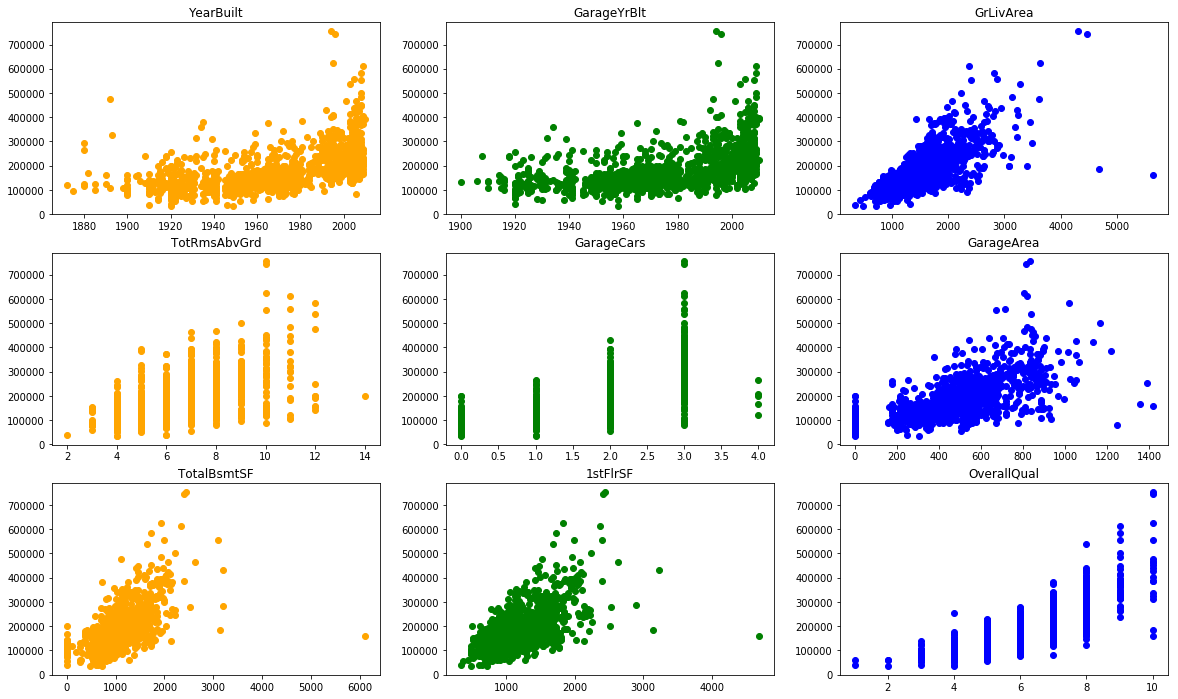

In [9]:
fig, axes = plt.subplots(nrows= 3,ncols = 3, figsize=(20,12))

axes[0,0].scatter(hp_train['YearBuilt'], hp_train['SalePrice'], color='orange')
axes[0,1].scatter(hp_train['GarageYrBlt'], hp_train['SalePrice'],  color='green')
axes[0,2].scatter(hp_train['GrLivArea'], hp_train['SalePrice'], color='blue')


axes[1,0].scatter(hp_train['TotRmsAbvGrd'], hp_train['SalePrice'],  color='orange')
axes[1,1].scatter(hp_train['GarageCars'], hp_train['SalePrice'], color='green')
axes[1,2].scatter(hp_train['GarageArea'], hp_train['SalePrice'],  color='blue')

axes[2,0].scatter(hp_train['TotalBsmtSF'], hp_train['SalePrice'],  color='orange')
axes[2,1].scatter(hp_train['1stFlrSF'], hp_train['SalePrice'], color='green')
axes[2,2].scatter(hp_train['OverallQual'], hp_train['SalePrice'],  color='blue')

#Naming Titles Of The Columns  
axes[0,0].set_title('YearBuilt')
axes[0,1].set_title('GarageYrBlt')
axes[0,2].set_title('GrLivArea')

axes[1,0].set_title('TotRmsAbvGrd')
axes[1,1].set_title('GarageCars')
axes[1,2].set_title('GarageArea')


axes[2,0].set_title('TotalBsmtSF')
axes[2,1].set_title('1stFlrSF')
axes[2,2].set_title('OverallQual')

###                                            Missing Values

### This are all  Columns with Null Values In The Train Csv 


In [10]:
#hp_train.isnull().sum().sort_values(ascending = False).head(20)
# columns that have NaN on the train dataset.
is_null=df_all.isnull().sum().sort_values(ascending=False)
NaN_train=(is_null[is_null>0])
dict(NaN_train)
NaN_train

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

### Visualization Of the Null Values In our Dataset

Text(0.5, 1.0, 'Missing  Data In The Dataset')

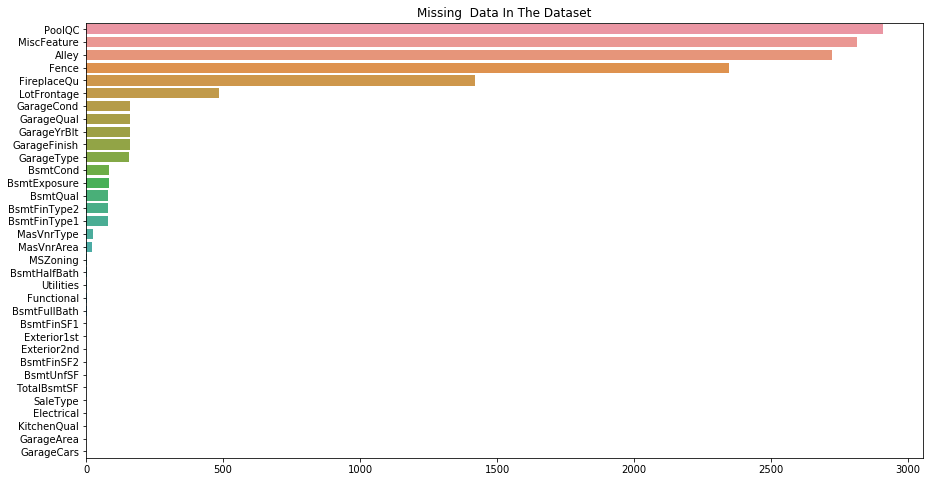

In [11]:
#THIS ARE THE VISUALS  TO SHOW THE MISSING DATA IN OUR DATASET ..THE COLUMNS WE SORTED IN THE Visualization
plt.figure(figsize=(15, 8))
sns.barplot(NaN_train,NaN_train.index)
plt.title('Missing  Data In The Dataset')


### Filling In The Missing Values 

In [12]:

df_all["PoolQC"] = df_all["PoolQC"].fillna("None")

df_all["MiscFeature"] = df_all["MiscFeature"].fillna("None")

df_all["Alley"] = df_all["Alley"].fillna("None")

df_all["Fence"] = df_all["Fence"].fillna("None")

df_all["FireplaceQu"] = df_all["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_all[col] =df_all[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_all[col] = df_all[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_all[col] = df_all[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_all[col] = df_all[col].fillna('None')
    
df_all["MasVnrType"] = df_all["MasVnrType"].fillna("None")
df_all["MasVnrArea"] = df_all["MasVnrArea"].fillna(0)

df_all['MSZoning'] = df_all['MSZoning'].fillna(df_all['MSZoning'].mode()[0])

df_all["Functional"] = df_all["Functional"].fillna("Typ")

df_all['Electrical'] = df_all['Electrical'].fillna(df_all['Electrical'].mode()[0])

df_all['KitchenQual'] = df_all['KitchenQual'].fillna(df_all['KitchenQual'].mode()[0])

df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0])
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])

df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])

df_all['MSSubClass'] = df_all['MSSubClass'].fillna("None")


### Analysing The Sales Price 
 
 * We Do This Since SalesPrice Is A Target Variable And It Is  What We Want To Predict

In [13]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
(mu, sigma) = norm.fit(saleprice['SalePrice'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


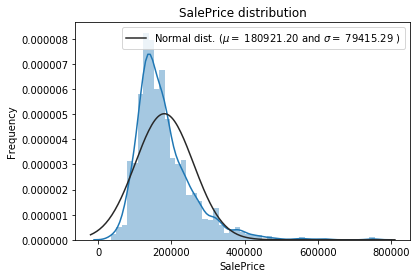

In [14]:
#We Used This Code To Check The skiweness Of The  Salesprice Column 
(mu, sigma) = norm.fit(saleprice['SalePrice'])
sns.distplot(saleprice['SalePrice'],fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')

* We Can See That Sales Price Is Not Normally Distributed
* We Need To See The Realtionship Using A Normal Probabilty Plot/Normal Quantile Plot

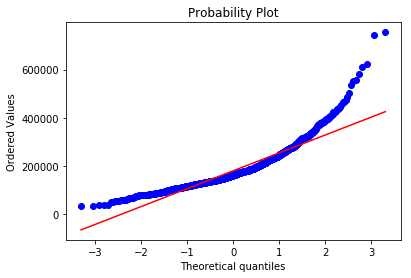

In [15]:
quantile_plot=stats.probplot(saleprice['SalePrice'], plot=plt)

* We Need To Look At How The Data/Obsevations Might Fall Closely To The Line
* We See That Most Of The Deviations Apear Mostly On The Left And The Right 
* This Is A Right Skewed Data Sets Tend To Be Close To Zero And Less Data Points In The Upper Bound / As We Get To Higher Values
* We Then Need To  Apply The Log Transformation  On The Sales Price Column To Make Sure That Atlist Most Of The Datapoints Fall On The Line Of the Q-Q plot
* we will use log(1+x) to do this

In [16]:
saleprice["SalePrice"] = np.log1p(saleprice["SalePrice"])
y=saleprice
y.head()

,SalePrice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220


#### The Following Two Graphs Shows The Skiewness Of Our Data And how It Looks Like When It Is Normalised  
* For The Data To Be Normalised The Blue Dots  Have To  Be Close To The Red Line
* On The Next Plot We Can See The Datapints Are Much Better Then Before

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


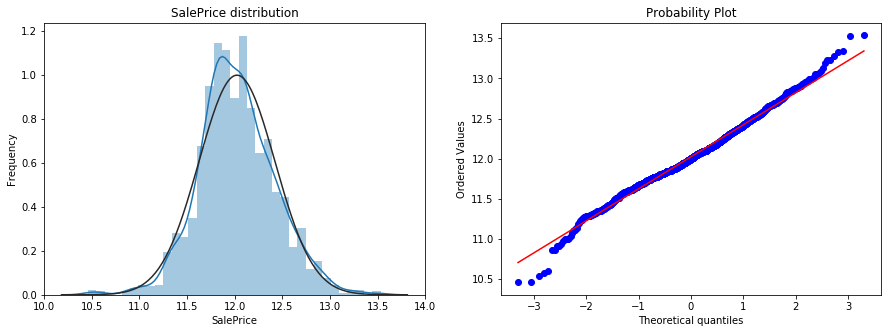

In [17]:
(mu, sigma) = norm.fit(saleprice['SalePrice'])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(saleprice['SalePrice'],fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1, 2, 2)
quantile_plot=stats.probplot(saleprice['SalePrice'], plot=plt)

### Box Plot Overallqual/Saleprice

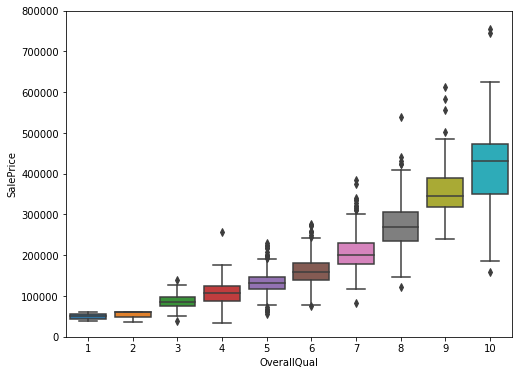

In [18]:
fat = 'OverallQual'
data = pd.concat([hp_train['SalePrice'], hp_train[fat]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=fat, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.savefig('lethabo.png')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

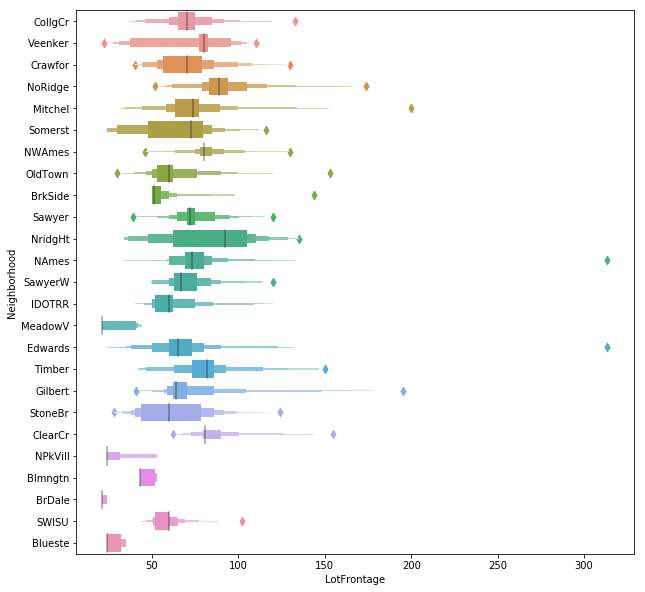

In [19]:
plt.figure(figsize=(10,10))
sns.boxenplot(df_all["LotFrontage"],df_all["Neighborhood"])

### Droping Columns That Have Less Correlation To Sales Price 

In [20]:
df_all=df_all.drop(['GarageYrBlt','TotRmsAbvGrd','GarageArea','PoolQC', 'MiscFeature', 'Fence','MiscVal','PoolArea','Utilities'], axis=1)

In [21]:
df_all['TotalBath'] = df_all['FullBath'] + df_all['HalfBath']*0.5 + df_all['BsmtFullBath'] + df_all['BsmtHalfBath']*0.5
df_all['TotalFlrSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF']
df_all['BsmtFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2']
# Deleting singulars since we have combined above:

singles_to_drop = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2']
for col in singles_to_drop:
    df_all.drop([col], axis =1, inplace = True)

* Colums We Droped Successfully On The Dataset
* If You Take A Look At The Dataset There Is Catergorial Values And Numerical Values And Machine Learning Only Understand Numbers
* We Will Have To Convert The Catergorial Values To Numerical By Getting Dummie Variables 

In [22]:

df_all.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition,TotalBath,TotalFlrSF,BsmtFinSF
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,150.0,856.0,GasA,Ex,Y,SBrkr,0,1710,3,1,Gd,Typ,0,None,Attchd,RFn,2.0,TA,TA,Y,0,61,0,0,0,2,2008,WD,Normal,3.5,1710,706.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,284.0,1262.0,GasA,Ex,Y,SBrkr,0,1262,3,1,TA,Typ,1,TA,Attchd,RFn,2.0,TA,TA,Y,298,0,0,0,0,5,2007,WD,Normal,2.5,1262,978.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,434.0,920.0,GasA,Ex,Y,SBrkr,0,1786,3,1,Gd,Typ,1,TA,Attchd,RFn,2.0,TA,TA,Y,0,42,0,0,0,9,2008,WD,Normal,3.5,1786,486.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,540.0,756.0,GasA,Gd,Y,SBrkr,0,1717,3,1,Gd,Typ,1,Gd,Detchd,Unf,3.0,TA,TA,Y,0,35,272,0,0,2,2006,WD,Abnorml,2.0,1717,216.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,490.0,1145.0,GasA,Ex,Y,SBrkr,0,2198,4,1,Gd,Typ,1,TA,Attchd,RFn,3.0,TA,TA,Y,192,84,0,0,0,12,2008,WD,Normal,3.5,2198,655.0


### Now The Data Is Clean We Convert Catergorial Values To Numerical 

In [23]:
df_all = pd.get_dummies(df_all)
X_test=df_all.iloc[train_length:,:]
X_train=df_all.iloc[:train_length,:]


In [24]:
X=X_train

In [25]:
df_all.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,TotalBath,TotalFlrSF,BsmtFinSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,150.0,856.0,0,1710,3,1,0,2.0,0,61,0,0,0,2,2008,3.5,1710,706.0,0,0,0,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,284.0,1262.0,0,1262,3,1,1,2.0,298,0,0,0,0,5,2007,2.5,1262,978.0,0,0,0,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,434.0,920.0,0,1786,3,1,1,2.0,0,42,0,0,0,9,2008,3.5,1786,486.0,0,0,0,1,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,540.0,756.0,0,1717,3,1,1,3.0,0,35,272,0,0,2,2006,2.0,1717,216.0,0,0,0,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,490.0,1145.0,0,2198,4,1,1,3.0,192,84,0,0,0,12,2008,3.5,2198,655.0,0,0,0,1,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


### Model Boosting
* Importing All The Liabriaries We Will Need To Boost Our Model  And The Nesessary Python Liabriries That We Might Need Later 

### Cross Validation
Cross Validation
We use the cross_val_score function of Sklearn in order for the model to be stacked together

In [26]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### The Base Models 

* We Going To Stack All The Models Together So That We Can Improve Our Predictive Score

#### Lasso  Regression 

In [27]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

####  Elastic Net Regression

In [28]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### Kernel Ridge Regression

In [29]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

####  GBoost Regression

In [30]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


#### Extreme Gradient Boosting XGB

In [31]:
import random
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.04, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =random.randint(0,int(2**16)), nthread = -1)


#### Light Gradient Boosting

In [32]:
lgb_model = lgb.LGBMRegressor(lcolsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.04, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =random.randint(0,int(2**16)), nthread = -1)

#### XGB

In [33]:
import random
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.04, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =random.randint(0,int(2**16)), nthread = -1)


### Base Models Scores

In [34]:
score = rmsle_cv(lasso)
print("\nLASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LASSO: 0.1354 (0.0290)



In [35]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1353 (0.0288)



In [36]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.142476e-19
  overwrite_a=False)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.856476e-18
  overwrite_a=False)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.144405e-18
  overwrite_a=False)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.703996e-19
  overwrite_a=False)
/opt/conda/lib/python3.6/sit

Kernel Ridge score: 0.5768 (0.1615)



In [37]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Gradient Boosting score: 0.1220 (0.0109)



In [38]:
score = rmsle_cv(model_xgb)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1219 (0.0101)



In [39]:
score = rmsle_cv(lgb_model)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Gradient Boosting score: 0.1274 (0.0077)



### We will Only Avarage Those Whicha Have Good Mean Scores

### Model Stacking

* The idea of stacking models just means we take the models we have tested and simply average them together in hopes of attaining a better score
* Averaged base models class**
* Averaged base models score**
* We just average four models here **ENet, GBoost,XGB,KNN,LGB,and lasso**.  Of course we could easily add more models in the mix. 

In [40]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [41]:
averaged_models = AveragingModels(models = (GBoost, lasso,KRR,model_xgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.142476e-19
  overwrite_a=False)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.856476e-18
  overwrite_a

 Averaged base models score: 0.1871 (0.0307)



### Predictions For Submittions

In [42]:
averaged_models.fit(X,y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.808724e-19
  overwrite_a=False)


AveragingModels(models=(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_...g_alpha=0.464, reg_lambda=0.8571, scale_pos_weight=1, seed=None,
       silent=1, subsample=0.5213)))

In [43]:
y_average=np.expm1(averaged_models.predict(X_test))

In [44]:
sales2=pd.DataFrame(y_average,columns=['SalePrice'])
sample_supmition['SalePrice']=sales2['SalePrice']
sample2.head()
sample2.to_csv('avg6.csv',index=False)